## Regression Project

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

### Define Dataset

In [210]:
df = pd.read_csv("housePrice.csv")

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [214]:
cdf = df[["Area", "Room", "Parking", "Warehouse", "Elevator", "Address", "Price(USD)"]] # Price(USD) is the label.
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 119.0+ KB


In [215]:
cdf = cdf.dropna()
cdf.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address       0
Price(USD)    0
dtype: int64

### Preprocessing

In [ ]:
# convert the value of "Area" from object to int64 and if its non-convertible the value will be nan.
cdf["Area"] = pd.to_numeric(cdf["Area"], errors="coerce")
cdf = cdf.dropna()

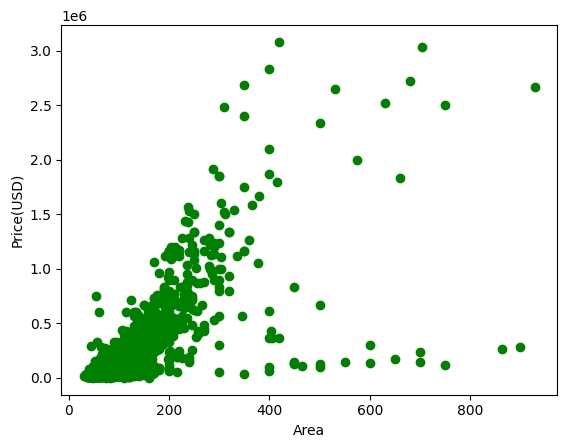

In [220]:
plt.scatter(cdf["Area"], cdf["Price(USD)"], color="green")
plt.xlabel("Area")
plt.ylabel("Price(USD)")
plt.show()

In [ ]:
# this cell drops outlier datas, I determined that if value of "Area" is more than 480 It is outlier.
Q3 = cdf["Area"].quantile(0.95)
IQR = Q3
upper_bound = Q3 + 1.5 * IQR

cdf["Area"] = cdf["Area"].where(cdf["Area"] <= upper_bound, np.nan) # value if less than 480 else nan.

cdf = cdf.dropna()

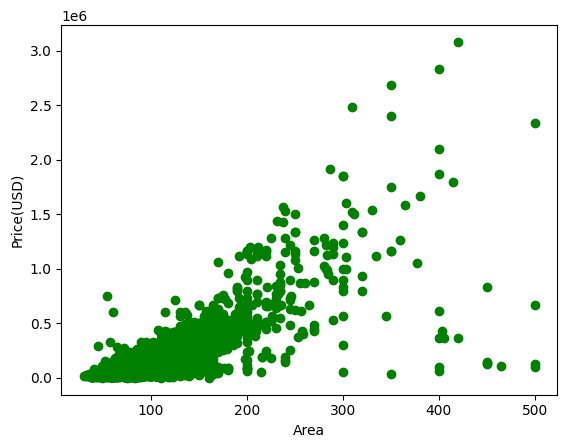

In [223]:
plt.scatter(cdf["Area"], cdf["Price(USD)"], color="green")
plt.xlabel("Area")
plt.ylabel("Price(USD)")
plt.show()

In [ ]:
# convert boolean values to int64.
cdf["Parking"] = cdf["Parking"].astype(int)
cdf["Warehouse"] = cdf["Warehouse"].astype(int)
cdf["Elevator"] = cdf["Elevator"].astype(int)

cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3433 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3433 non-null   float64
 1   Room        3433 non-null   int64  
 2   Parking     3433 non-null   int64  
 3   Warehouse   3433 non-null   int64  
 4   Elevator    3433 non-null   int64  
 5   Address     3433 non-null   object 
 6   Price(USD)  3433 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 214.6+ KB


In [ ]:
# achieve classes of "Address" to choose the way of encoding (Lable Encoder, One Hot Encoding or Target Encoding).
address_group = cdf.groupby("Address")
address_group.count()

,Area,Room,Parking,Warehouse,Elevator,Price(USD)
Address,,,,,,
Abazar,22,22,22,22,22,22
Abbasabad,2,2,2,2,2,2
Absard,4,4,4,4,4,4
Abuzar,3,3,3,3,3,3
Afsarieh,6,6,6,6,6,6
...,...,...,...,...,...,...
Yousef Abad,38,38,38,38,38,38
Zafar,9,9,9,9,9,9
Zaferanieh,27,27,27,27,27,27


In [ ]:
# split data to train and test.
msk = np.random.rand(len(cdf)) < 0.8

data_train, data_test = cdf[msk], cdf[~msk]

data_train.shape, data_test.shape

((2755, 7), (678, 7))

In [ ]:
# I used target encoding to encode "Address".
data_train = data_train.copy() # because of warning message.
mean_prices = data_train.groupby("Address")["Price(USD)"].mean()
data_train["Address_Encoded"] = data_train["Address"].map(mean_prices)

data_train.drop("Address", axis=1, inplace=True) # we dont need "Address" anymore.
data_train.head()

,Area,Room,Parking,Warehouse,Elevator,Price(USD),Address_Encoded
0,63.0,1,1,1,1,61666.67,102591.919697
1,60.0,1,1,1,1,61666.67,102591.919697
2,79.0,2,1,1,1,18333.33,26134.159669
3,95.0,2,1,1,1,30083.33,31039.570000
4,123.0,2,1,1,1,233333.33,393021.568431


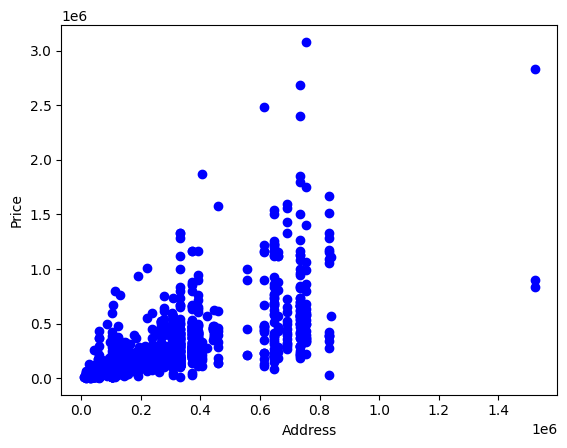

In [231]:
plt.scatter(data_train["Address_Encoded"], data_train["Price(USD)"], color="blue")
plt.xlabel("Address")
plt.ylabel("Price")
plt.show()

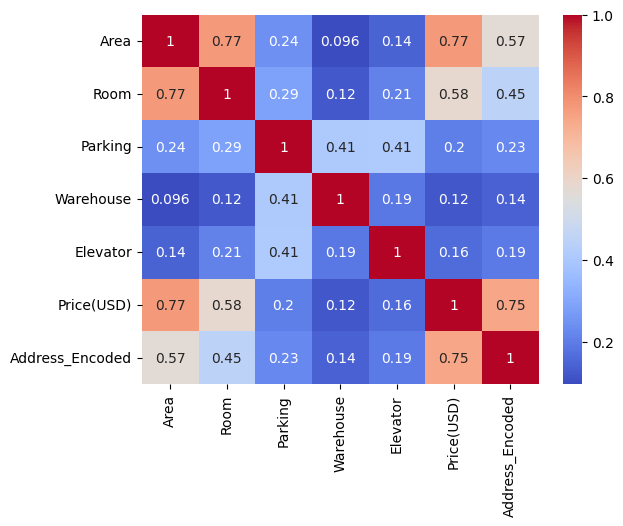

In [ ]:
# to see correlation between features and label it is important to use train data for this process only.
corr = data_train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [234]:
# we use features with hight correlations for training.
x_train = np.asanyarray(data_train[["Area", "Room", "Parking", "Address_Encoded"]])
y_train = np.asanyarray(data_train[["Price(USD)"]])

## Polynomial Regression

### Model Definition

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
x_train_poly = poly.fit_transform(x_train)

array([[1.00000000e+00, 6.30000000e+01, 1.00000000e+00, 1.00000000e+00,
        9.81387886e+04, 3.96900000e+03, 6.30000000e+01, 6.30000000e+01,
        6.18274368e+06, 1.00000000e+00, 1.00000000e+00, 9.81387886e+04,
        1.00000000e+00, 9.81387886e+04, 9.63122184e+09, 2.50047000e+05,
        3.96900000e+03, 3.96900000e+03, 3.89512852e+08, 6.30000000e+01,
        6.30000000e+01, 6.18274368e+06, 6.30000000e+01, 6.18274368e+06,
        6.06766976e+11, 1.00000000e+00, 1.00000000e+00, 9.81387886e+04,
        1.00000000e+00, 9.81387886e+04, 9.63122184e+09, 1.00000000e+00,
        9.81387886e+04, 9.63122184e+09, 9.45196444e+14, 1.57529610e+07,
        2.50047000e+05, 2.50047000e+05, 2.45393097e+10, 3.96900000e+03,
        3.96900000e+03, 3.89512852e+08, 3.96900000e+03, 3.89512852e+08,
        3.82263195e+13, 6.30000000e+01, 6.30000000e+01, 6.18274368e+06,
        6.30000000e+01, 6.18274368e+06, 6.06766976e+11, 6.30000000e+01,
        6.18274368e+06, 6.06766976e+11, 5.95473760e+16, 1.000000

In [205]:
model = LinearRegression()
model.fit(x_train_poly, y_train)

print(f"coefficient : {mymodel.coef_[0]} | intercept : {mymodel.intercept_[0]}")

coefficient : [ 2.87475043e+03 -3.22617012e+04 -1.04207261e+04  5.76539819e-01] | intercept : -147215.48415178328


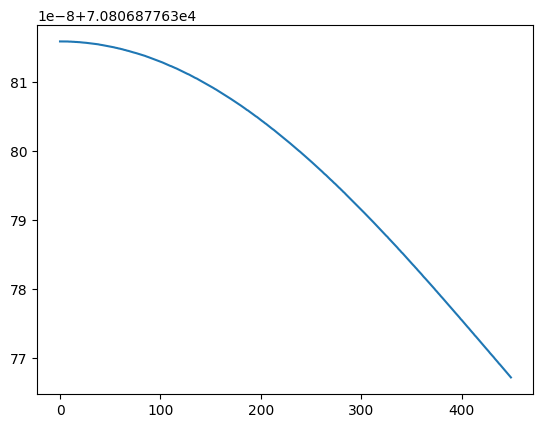

In [207]:
x = np.arange(0, 450, 1)
y = model.intercept_[0] + model.coef_[0][0] * x + model.coef_[0][1] * (np.pow(x, 2)) + model.coef_[0][2] * (np.pow(x, 3)) + model.coef_[0][3] * (np.pow(x, 4))
plt.plot(x, y)
plt.show()

### model evaluation

In [ ]:
x_test_poly = poly.fit_transform(x_test)
y_pred_poly = model.predict(x_test_poly)

In [209]:
msee = np.mean((y_test - y_pred_poly) ** 2)
maee = np.mean(np.absolute(y_test - y_pred_poly))
r22 = r2_score(y_test, y_pred_poly)

print(f"mean squared error : {msee} | mean absolute error : {maee} | r2 score : {r22}".title())

Mean Squared Error : 14575425180.148869 | Mean Absolute Error : 61229.50483540903 | R2 Score : 0.7631874702486688
